In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

Table of Contents
    1. Data Preprocessing
    2. Linear Regression
        1. Standard Linear Regression
        2. ElasticNet
        3. Lasso
        4. Comparison of Methods
    3. Classification
        1. Setup
        2. Classifier Evaluation (With 3 bins and 4 bins)
        3. Learning Curves
        4. Feature Importance Rankings

In [2]:
sns.set_style()
path = 'Pickles/output_df.pkl'
df = pd.read_pickle(path)
df.columns

Index(['artists', 'date', 'TM_id', 'event_title', 'presale_date_end',
       'presale_date_start', 'promoter', 'TM_sale_date_start',
       'span multiple days', 'venue', 'TM_venue _lat', 'venue_city',
       'TM_venue_long', 'venue_state', 'TM_max', 'TM_min', 'genre', 'subGenre',
       'event_type', 'SG_artists_score', 'SG_average_price',
       'SG_listing_count', 'SG_max_price', 'SG_min_price', 'SG_venue_score',
       'SH_max_price', 'SH_min_price', 'SH_total_postings', 'SH_total_tickets',
       'spotify_followers', 'spotify_popularity', 'spotify_avg_followers',
       'spotify_avg_popularity', 'spotify_null_count', 'days_until_show',
       'day_of_week', 'presale_length', 'days_on_sale', 'artist_count',
       'avg_resale_min', 'avg_resale_max', 'min_source', 'max_source',
       'min_markup%', 'max_markup%', 'avg_ticket_listings'],
      dtype='object')

## 1. Data Preprocessing
Drop extra columns and one hot encode categorical features (Dropping the first category to avoid collinearity)

In [3]:
##Drop excess columns 
df = df[['min_markup%','promoter','venue_state','TM_min','genre','subGenre','spotify_avg_followers',
         'spotify_avg_popularity','spotify_null_count','days_until_show','day_of_week',
         'presale_length','days_on_sale','artist_count','min_source','avg_ticket_listings']]

In [4]:
#One Hot Encode categorical variables
df_onehot = pd.get_dummies(columns=['promoter','venue_state','genre','min_source','subGenre','day_of_week'],
                           data=df,drop_first=True)

#Seperate into X and Y matrices
X = df_onehot.iloc[:,1:]
Y = df_onehot['min_markup%']

#Split into training and test set
X,X_test,Y,Y_test =  train_test_split(X,Y,test_size=.2,random_state=1)

#Scale numerical data
cont_features = ['TM_min','spotify_avg_followers',
'spotify_avg_popularity','days_until_show','presale_length','days_on_sale',
 'artist_count','avg_ticket_listings']
Xscaler = StandardScaler()
X[cont_features] = Xscaler.fit_transform(X[cont_features])
X_test[cont_features] = Xscaler.transform(X_test[cont_features])

#Create log scaled Y data for train and test data sets
Y_log = Y.copy()
Y_log[Y_log <= 0] = .01
Y_log = np.log(Y_log)

Y_testlog = Y_test.copy()
Y_testlog[Y_testlog <= 0] = .01
Y_testlog = np.log(Y_testlog)

## 2. Linear Regression
    1. Model Comparison
    2. Residual Plots
    
### 2.1 Model Comparison

In [5]:
# Make MSE and R squared CV scorers
cv_mse = metrics.make_scorer(score_func=metrics.mean_squared_error)
cv_r = metrics.make_scorer(score_func=metrics.r2_score)
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

#Initialize regression objects
lr = linear_model.LinearRegression()
en = linear_model.ElasticNetCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
lasso = linear_model.LassoCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
abr = ensemble.AdaBoostRegressor(random_state=1)
gbr = ensemble.GradientBoostingRegressor(random_state=1)
rfr = ensemble.RandomForestRegressor(random_state=1)

#Initialize regression objects to train with log transformed Y data
lr_log = linear_model.LinearRegression()
en_log = linear_model.ElasticNetCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
lasso_log = linear_model.LassoCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
abr_log = ensemble.AdaBoostRegressor(random_state=1)
gbr_log = ensemble.GradientBoostingRegressor(random_state=1)
rfr_log = ensemble.RandomForestRegressor(random_state=1)

lin_models = {'Standard': lr,
             'ElasticNet' : en,
             'Lasso' : lasso,
             'Ada Boosting' : abr,
             'Gradient Boosting': gbr,
             'Random Forest': rfr}
lin_models_log = {'Standard Log': lr_log,
             'ElasticNet Log' : lr_log,
             'Lasso Log' : lasso_log,
             'Ada Boosting Log' : abr_log,
             'Gradient Boosting Log': gbr_log,
             'Random Forest Log': rfr_log}

def fit_lin_regression(model,name,Y=Y):
    #Calculate R Values
    r_values = cross_val_score(estimator=model,X=X,y=Y,cv=kfold,scoring=cv_r)
    #Calculate MSE Values
    mse_values = cross_val_score(estimator=model,X=X,y=Y,cv=kfold,scoring=cv_mse)
    
    model.fit(X,Y)
    #Create dataframe of coefficients and weights
    try:
        coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient': model.coef_})
        # Find number of coefficients
        coef_total = len(coef_df['Coefficient'].loc[coef_df['Coefficient'] != 0])
    except AttributeError:
        coef_df = np.nan
        coef_total = np.nan
    
    #Append R^2 and MSE metrics to lists
    avg_r2_train.append(r_values.mean())
    std_r2_train.append(r_values.std())
    avg_mse_train.append(mse_values.mean())
    std_mse_train.append(mse_values.std())
    coef_count.append(coef_total)
    coef_weights[name] = coef_df

def predict_lin_regression(model,name,Y_test=Y_test):
    y_pred = model.predict(X_test)
    mse_test.append(metrics.mean_squared_error(Y_test,y_pred))
    r2_test.append(metrics.r2_score(Y_test,y_pred))
    
def plot_residuals(model,name,X=X,Y=Y):
    Y_fitted= model.predict(X=X)
    residuals = np.subtract(Y_fitted,Y)
    g = plt.scatter(Y_fitted,residuals,alpha=.4)
    return g

In [8]:
#Create lists of model metrics for train data
avg_r2_train = []
std_r2_train = []
avg_mse_train = []
std_mse_train = []
coef_count = []
coef_weights = dict()

#Evaluate models
for key in lin_models.keys():
    fit_lin_regression(lin_models[key],key)
    
#Evaluate models (With Log Transformed Y)
for key in lin_models_log.keys():
    fit_lin_regression(lin_models_log[key],key,Y=Y_log)

reg_models = [key for key in lin_models.keys()] + [key for key in lin_models_log.keys()]

#Create dataframe of models and metrics
results_df = pd.DataFrame({'Model' : reg_models,
                           'R2 Mean' : avg_r2_train,
                           'R2 Std' : std_r2_train,
                           'MSE Mean' : avg_mse_train,
                           'MSE Std' : std_mse_train,
                           'Coefficients Count' : coef_count})

results_df[['Model','R2 Mean','R2 Std','MSE Mean','MSE Std','Coefficients Count']]

,Model,R2 Mean,R2 Std,MSE Mean,MSE Std,Coefficients Count
0,Standard,0.189592,0.094146,84555.486480,22199.238489,74.0
1,ElasticNet,0.161507,0.058729,87752.332366,22725.831103,73.0
2,Lasso,0.190991,0.089336,84493.909526,22226.669894,65.0
3,Ada Boosting,0.007987,0.591914,107593.552671,80899.270100,NaN
4,Gradient Boosting,0.635514,0.172276,39072.182636,23130.587541,NaN
5,Random Forest,0.587575,0.197062,43085.135319,23121.945424,NaN
6,Standard Log,0.167218,0.046321,1.756009,0.408149,74.0
7,ElasticNet Log,0.167218,0.046321,1.756009,0.408149,74.0
8,Lasso Log,0.140746,0.030420,1.806866,0.387574,14.0
9,Ada Boosting Log,-0.570153,0.571515,3.250107,1.222295,NaN


In [9]:
#Create lists of metrics on test data
r2_test = []
mse_test = []

#Evaluate models on the test data
for key in lin_models.keys():
    predict_lin_regression(lin_models[key],key)
    
#Evaluate models (With Log Transformed Y)
for key in lin_models_log.keys():
    predict_lin_regression(lin_models_log[key],key,Y_test=Y_testlog)

#Create dataframe of models and metrics
test_results_df = pd.DataFrame({'Model' : reg_models,
                                'R2' : r2_test,
                                'MSE' : mse_test})
                 
test_results_df[['Model','R2','MSE']]

,Model,R2,MSE
0,Standard,0.307016,78229.274482
1,ElasticNet,0.248492,84835.865052
2,Lasso,0.302703,78716.149068
3,Ada Boosting,0.226271,87344.358584
4,Gradient Boosting,0.680441,36074.203149
5,Random Forest,0.739273,29432.817013
6,Standard Log,0.081162,1.978125
7,ElasticNet Log,0.081162,1.978125
8,Lasso Log,0.067036,2.008537
9,Ada Boosting Log,0.003004,2.146389


### Analysis:
MSE and $R^2$ values are similar on the train and test data, suggesting the models are not particularly overfitting

## 2.2 Residual Plots

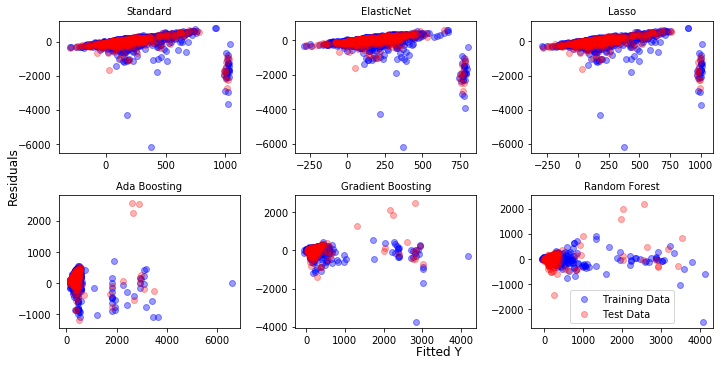

In [10]:
#Residual plots

subplt = 1
f, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=[10,5])

for key in lin_models.keys():
    plt.subplot(2,3,subplt)
    plt.title(key,size='medium')
    trainplot = plot_residuals(lin_models[key],key,X=X)
    testplot = plot_residuals(lin_models[key],key,X=X_test,Y=Y_test)
    trainplot.set_color('b')
    testplot.set_color('r')
    testplot.set_alpha(.3)
    subplt +=1
f.text(0.6, 0, 'Fitted Y', ha='center',size='large')
f.text(0, 0.5, 'Residuals', va='center', rotation='vertical',size='large')
plt.tight_layout()
plt.legend([trainplot,testplot],['Training Data','Test Data'],loc='best')
plt.show()

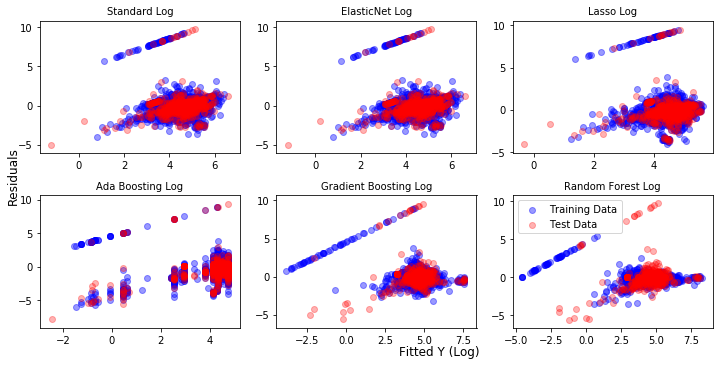

In [11]:
# Residuals with Y log transformation
subplt = 1
f, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=[10,5])

for key in lin_models_log.keys():
    plt.subplot(2,3,subplt)
    plt.title(key,size='medium')
    trainplot = plot_residuals(lin_models_log[key],key,Y=Y_log)
    trainplot.set_color('b')
    testplot = plot_residuals(lin_models_log[key],key,X=X_test,Y=Y_testlog)
    testplot.set_color('r')
    testplot.set_alpha(.3)
    subplt +=1
f.text(0.6, 0, 'Fitted Y (Log)', ha='center',size='large')
f.text(0, 0.5, 'Residuals', va='center', rotation='vertical',size='large')
plt.legend([trainplot,testplot],['Training Data','Test Data'],loc='best')
plt.tight_layout()
plt.show()

### Analysis
How to interpret MSE vs R squared?

## 3. MultiClass Classification
    1. Variable & Function Setup
    2. Classifier Evaluation with 3 & 4 Bins
    3. Learning Curves
    4. Feature Importance Rankings

In [12]:
#Setup stratified KFold
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

#Initialize classifier objects
lgr = linear_model.LogisticRegression(penalty="l1",solver='saga',max_iter=10000,multi_class='multinomial')
rfc = RandomForestClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
abc = AdaBoostClassifier(random_state=1)
classifiers = [lgr,rfc,gbc,abc]
algo_list = ["Logistic Regression","Random Forest",
             "Gradient Boosting",'Ada Boosting']

In [13]:
def classifier_eval(classifiers,bins):
   # Classify Y values into bins
    Y_bins, bins = pd.qcut(Y,q=bins,retbins=True,labels=list(range(bins)))
    
    cv_results = []
    cv_means = []
    cv_std = []
    
    #Evaluate each classifier
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X, Y_bins, 
                                      scoring = 'accuracy',cv = cv))
    #Split into result means and standard deviations
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
    
    #Draw dataframe of results
    cv_res = pd.DataFrame(
        {"CrossValMeans":cv_means,
         "CrossValerrors": cv_std,
         "Algorithm":algo_list})
    
    g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
   
    return Y_bins, bins, cv_res, g

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

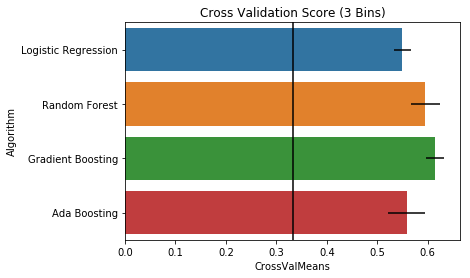

In [14]:
#Evaluate with 3 bins
Y_bins3, bins3_labels, cv_res3, g3 = classifier_eval(classifiers,bins=3)
g3.set_title("Cross Validation Score (3 Bins)")
plt.axvline(np.divide(1,3), color="black")
plt.show()

In [15]:
print("Markup Percentage Bins:\n [{} - {}), \n [{} - {}), \n [{} - {})".format(bins3_labels[0],bins3_labels[1],
                                                                 bins3_labels[1],bins3_labels[2],
                                                                 bins3_labels[2],bins3_labels[3]))

Markup Percentage Bins:
 [-72.53731343283583 - 84.32735042735041), 
 [84.32735042735041 - 125.0), 
 [125.0 - 6578.999999999999)


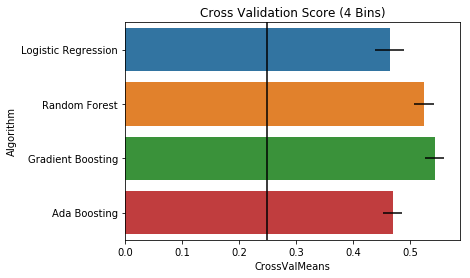

In [16]:
#Evaluate with 4 bins
Y_bins4, bins4_labels, cv_res4, g4 = classifier_eval(classifiers,bins=4)
g4.set_title("Cross Validation Score (4 Bins)")
plt.axvline(np.divide(1,4), color="black")
plt.show()

In [17]:
print("Markup Percentage Bins:\n [{} - {}), \n [{} - {}), \n [{} - {}), \n [{} - {}]".format(bins4_labels[0],bins4_labels[1],
                                                                 bins4_labels[1],bins4_labels[2],
                                                                 bins4_labels[2],bins4_labels[3],
                                                                 bins4_labels[3],bins4_labels[4]))

Markup Percentage Bins:
 [-72.53731343283583 - 75.65390969162995), 
 [75.65390969162995 - 101.55714285714285), 
 [101.55714285714285 - 146.66666666666666), 
 [146.66666666666666 - 6578.999999999999]


## 3.3 Learning Curves

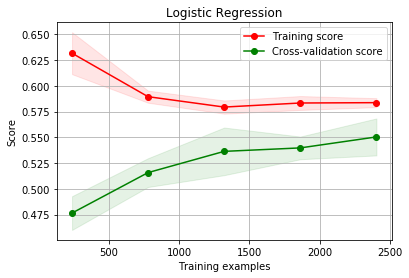

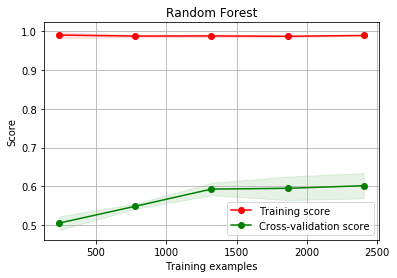

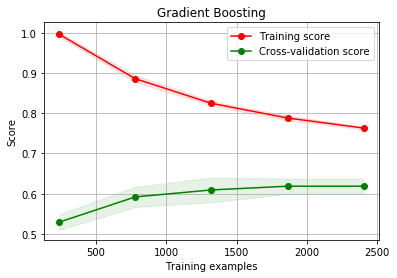

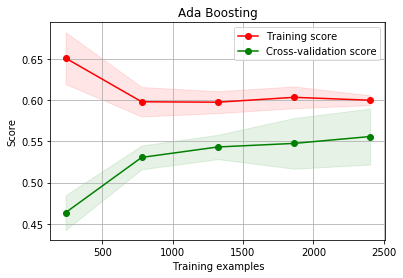

In [18]:

g1=plot_learning_curve(lgr, 'Logistic Regression', X, Y_bins3, ylim=None, cv=cv,
                       n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

g2=plot_learning_curve(rfc, 'Random Forest', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

g3=plot_learning_curve(gbc, 'Gradient Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

g4=plot_learning_curve(abc, 'Ada Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

plt.show()

## 3.4 Tree Classifiers Feature Importance (With Three Bins)

In [19]:
#Fit each classifier
for classifier in classifiers[1:]:
    classifier.fit(X,Y_bins3)

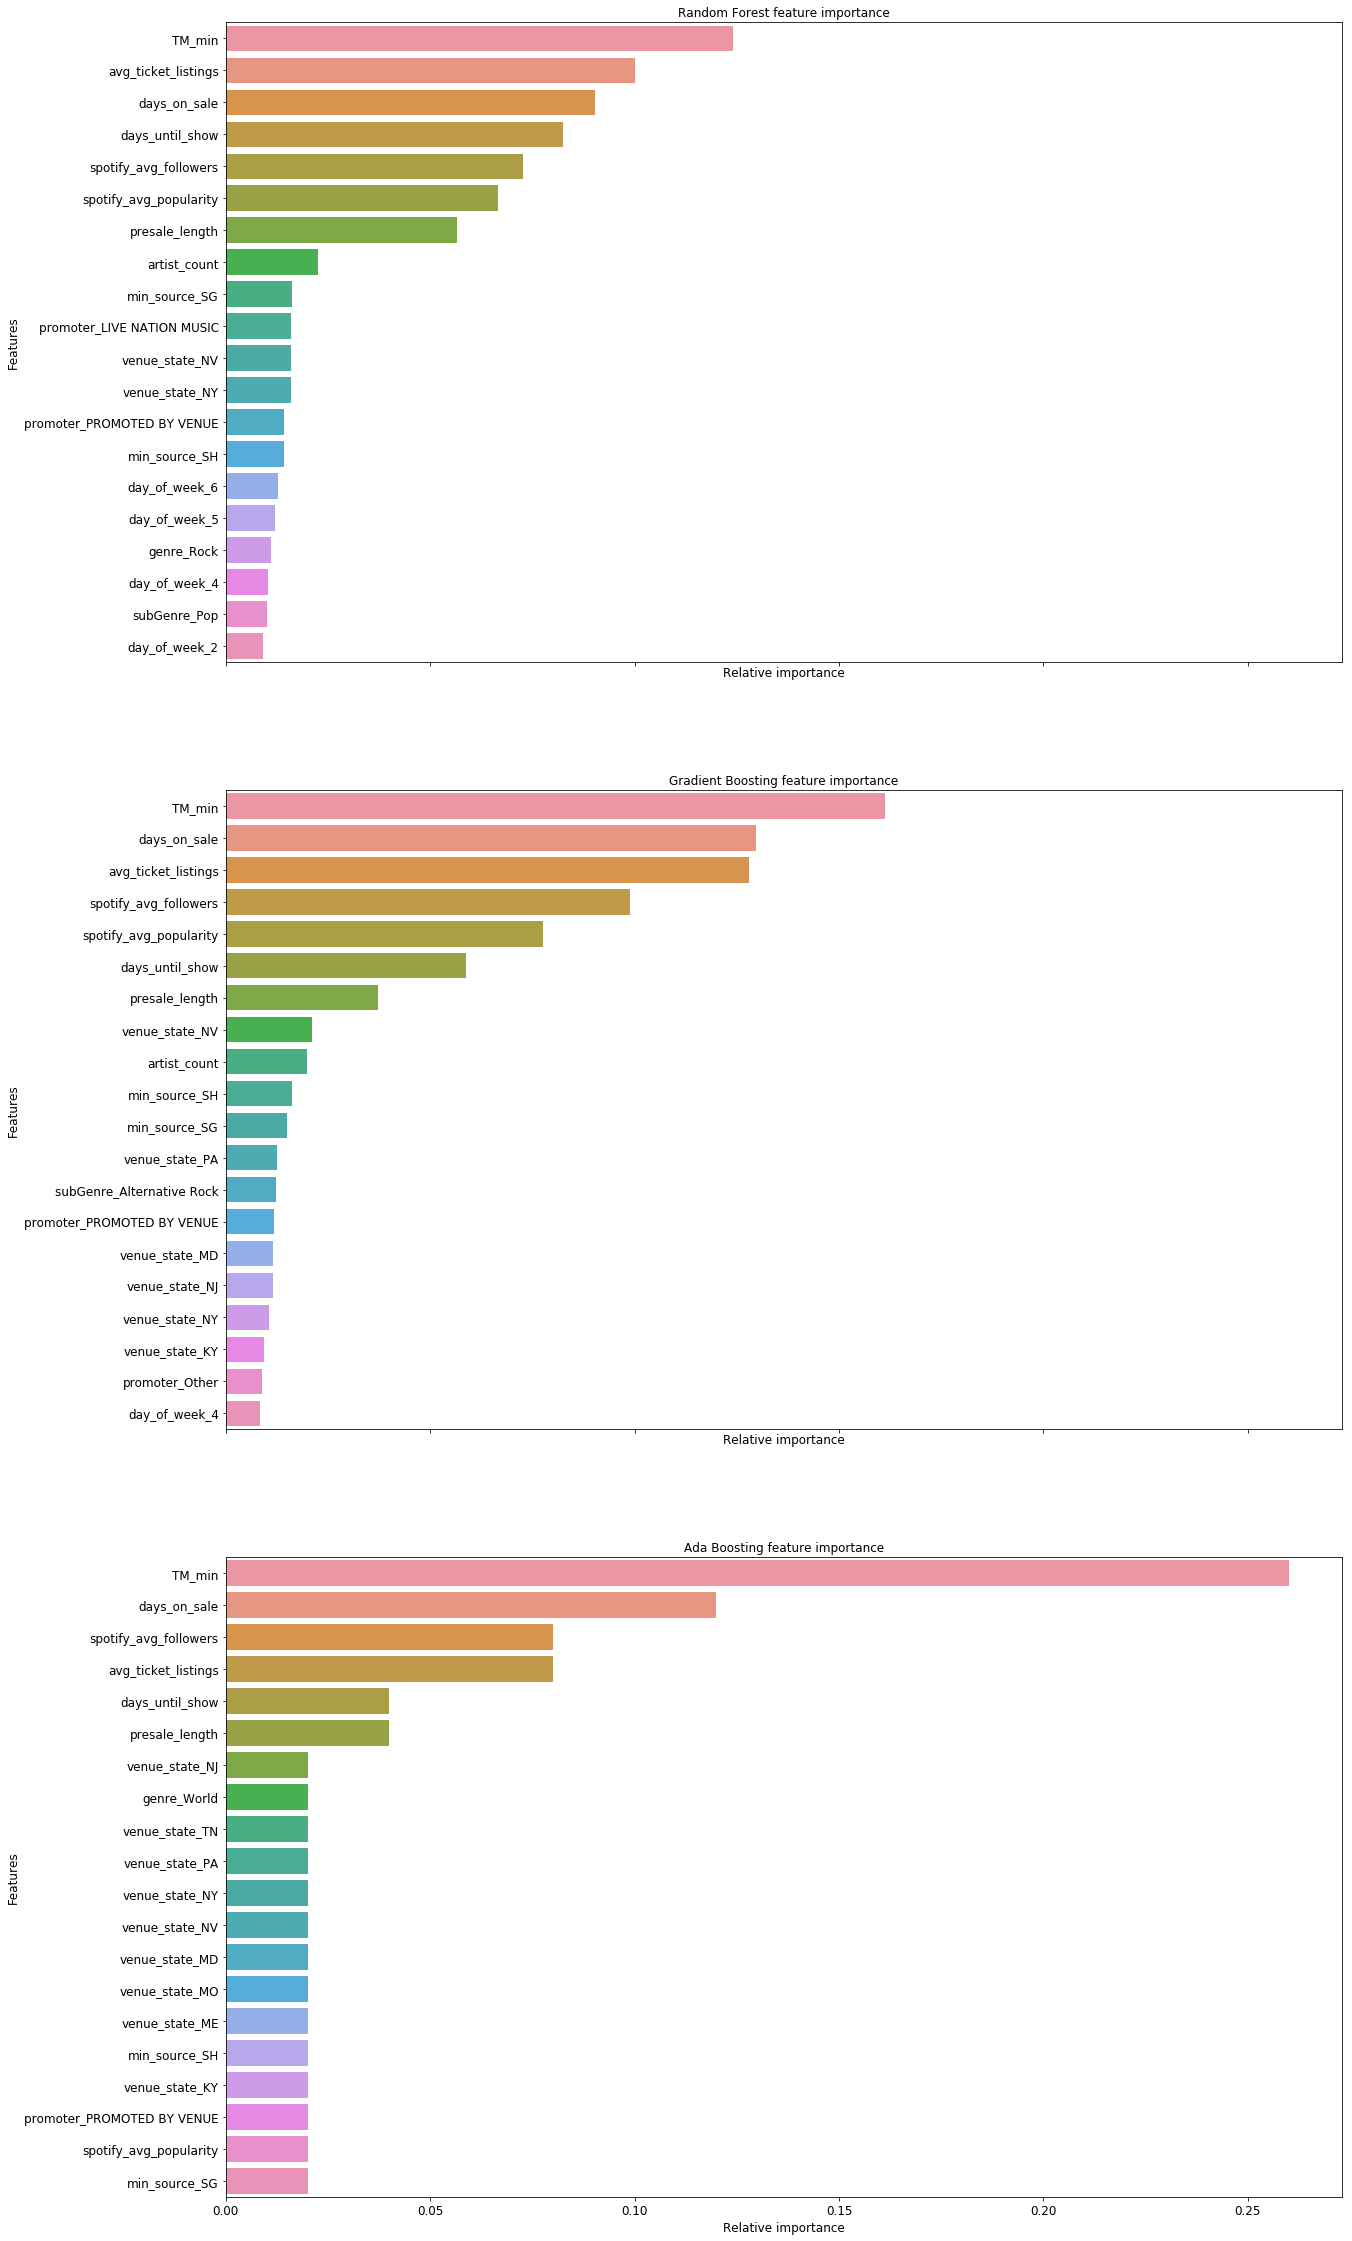

In [20]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,40),squeeze=False)

names_classifiers = [("Random Forest", rfc),("Gradient Boosting",gbc),("Ada Boosting",abc)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=12)
        g.set_title(name + " feature importance")
        nclassifier += 1

### Analysis:
Feature importance varies by classifier. However, the top seven features of each classifier (In varying orders) are TM min, Days on Sale, Spotify Average Followers, Average Ticket Listings, Days until Show, and Presale Length

## 3.5 Hyperparameter Tuning
I tune the hyperparameters of Logistic Regression, Random Forest, and Gradient Boosting classifiers using the training data (Target data is in 3 bins). Then, I combine the the three optimized models into a voting classifier and compare the results on the test data that was set aside earlier.

In [ ]:
#Split Y test data into the same three bins
Y_test3bins = pd.cut(x=Y_test,bins=bins3_labels,right=True,labels=[0,1,2])

In [ ]:
#Setup Logistic Regression GridSearchCV
lgr_params = {'C' : np.logspace(-3,1,10)}
lgr_gs = GridSearchCV(lgr,param_grid=lgr_params,cv=cv,verbose=1,scoring='accuracy')

#Setup Random Forest GridSearchCV
rfc_params = {'criterion': ['gini','entropy'],
              'max_features': ['auto','sqrt','log2'],
              'min_samples_split': [.001,.005,.01]}
rfc_gs = GridSearchCV(rfc,param_grid=rfc_params,cv=cv,verbose=1,scoring='accuracy')

#Setup Gradient Boosting GridSearchCV
gbc_params = {'n_estimators' : [100,200,300],
              'max_depth': np.logspace(0,1,5),
              'max_features' : ['auto','sqrt','log2']}
gbc_gs = GridSearchCV(gbc,param_grid=gbc_params,cv=cv,verbose=1,scoring='accuracy')

#Tune each GridSearchCV object
gs_list = [lgr_gs,rfc_gs,gbc_gs]
best_score = []
for gs in gs_list:
    gs.fit(X,Y_bins3)
    best_score.append(gs.score(X_test,Y_test3bins))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.5s finished


Fitting 5 folds for each of 45 candidates, totalling 225 fits


## 3.6 Model Ensembling and Comparison on Test Set

In [ ]:
#Create list of clfs with best parameters and their labels
best_clf = []
for gs in gs_list:
    best_clf.append(gs.best_estimator_)
estimators = list(zip(['Logistic Regression','Random Forest','Gradient Boosting'],best_clf))

#Initialize Voting Classifier
votingClf = ensemble.VotingClassifier(estimators=estimators,voting='soft')
votingClf.fit(X=X,y=Y_bins3)
best_score.append(votingClf.score(X=X,y=Y_test3bins))

#Wrap results into a dataframe    
clf_test_results = pd.DataFrame({'Classifier' : ['Logistic Regression','Random Forest','Gradient Boosting','Combined'],
                                'Best Score' : best_score})
#Plot results
sns.barplot(x='Best Score',y='Classifier',data=clf_test_results)
plt.axvline(np.divide(1,3), color="black")
plt.show()

## 4. Neural Net with Keras & Tensorflow

In [ ]:
# Keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
dummy_y = np_utils.to_categorical(Y_bins3)

In [ ]:
def build_base_model():# Model 
    model = Sequential()
    #input layer
    model.add(Dense(units=74,input_dim=74,activation='relu',))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    #hidden layers
    model.add(Dense(38,activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # output layer
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
#model compile for classification
#estimator = build_base_model()
#model.fit(X, dummy_y, epochs=100, batch_size=30)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
estimator = KerasClassifier(build_fn=build_base_model,epochs=100, batch_size=30)
score = cross_val_score(estimator,X=X,y=Y_bins3,cv=kfold,scoring='accuracy',verbose=1)

In [ ]:
score.mean()